# Word Level OCR for Persian Language
## Based on Recurrent Neural Networks
Amirabbas Asadi, amir137825@gmail.com

## Requirements
- Pandas, Numpy
- Pytorch
- OpenCV
- imgaug

## Dataset
I created a Synthetic dataset called Shotor containing 120000 images and correspond words.  
[Download The Dataset](https://github.com/amirabbasasadi/Shotor)

## Loading and using images

In [1]:
from imgaug import augmenters as iaa
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('dark')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from random import randint

### Some configurations

In [2]:
img_width = 100
img_height = 50
img_splits = 20
word_max_len = 15
device = 'cpu' 

### Set dataset path

In [3]:
!mkdir shotor

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tarfile
file = tarfile.open('/content/drive/MyDrive/NLP/Shotor_Images.tar.gz')
file.extractall('/content/shotor/')  
file.close()

In [6]:
dataset_path = '/content/shotor/Shotor_Images/'
csv_words_path = '/content/drive/MyDrive/NLP/Shotor_Words.csv'

### Creating dataset object
It is easier to define a dataset object for using data for Pytorch models

In [7]:
class PersianOCR(Dataset):
    """Persian Hand-Written dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # read the csv file
        self.csv = pd.read_csv(csv_file)
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        word = self.csv.iloc[idx, 1]
        image = io.imread(img_name)
        
        item = {'image': image, 'word': word}

        if self.transform:
            item = self.transform(item)

        return item

dataset = PersianOCR(csv_words_path, dataset_path)

### Checking the raw dataset
Take a look at some random words from dataset

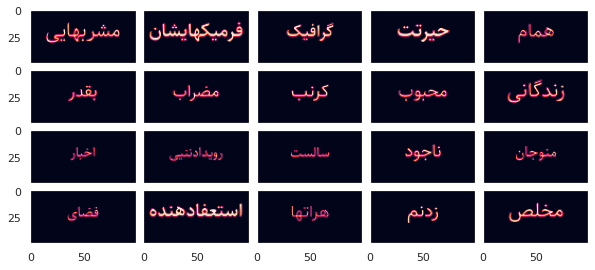

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  images.append(dataset[randint(0, len(dataset)-1)]['image'])

for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

### Converting Words and Images to Pytorch Tensors
We should define all persian alphabets.
Also we define `S` as start token and `E` as end token and `-` as blank character which is used for CTCLoss that we wanna use and is different from space character.

In [9]:
# define all persian alphabets
pchars = "آ ا ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی ئ"
pchars = ['-',' ', 'S', 'E'] + pchars.split(' ')
letter_to_index = {}
for i in range(len(pchars)):
  letter_to_index[pchars[i]] = i
enc_dim = len(pchars)

In [10]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        image = image.reshape(-1, img_height, img_width)
        if (len(word) > word_max_len):
          word = word[:word_max_len]
        word = word + 'E'
        original_word = [[letter_to_index[c]] for c in word]
        return {'image': torch.from_numpy(image).double(),
                'word' : torch.LongTensor(original_word)}

### Augmentation Pipeline
using imgaug we can define an Augmentation pipeline. It helps to train a robust model and useable for more realistic data. It randomly applies some of 5 augmentations.

In [11]:
class ImageAug(object):
    """Apply Image Augmentation on style and output"""

    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        aug = iaa.SomeOf((0, 5), [
            iaa.Affine(scale={"x": (0.80, 1.20), "y": (0.80, 1.20)}),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
            iaa.Add((-30, 30)),
            iaa.Multiply((0.80, 1.20)),
            iaa.GaussianBlur(sigma=(0, 0.2))
        ])
        image = aug(images=image)
        return {'image': image,
                'word': word}


### Create Dataset with Transformations

In [12]:
transformed_dataset = PersianOCR(csv_words_path, dataset_path,
                                 transform=transforms.Compose([ImageAug(), ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=True)

### See some samples from transformed dataset

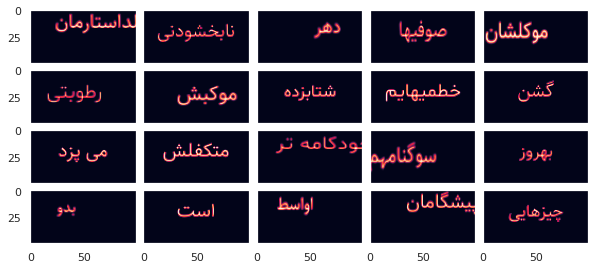

In [13]:
dataiter = iter(dataloader)

fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  batch = dataiter.next()
  images.append(batch['image'][0][0])

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

## Defining a Recurrent Neural Network in Pytorch

In [14]:
import torch.nn as nn

class OCRNet(nn.Module):
    def __init__(self, img_size, hidden_size):
        super(OCRNet, self).__init__()
        self.hidden_size = hidden_size
        self.img_size = img_size
        self.enc_img_size = 200
        self.fc1 = nn.Linear(self.img_size, 450)
        self.fc2 = nn.Linear(450, self.enc_img_size)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.CELU()
        self.i2h = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 80)
        self.h2h = nn.Linear(80, 60)
        self.h2h2 = nn.Linear(60, self.hidden_size)
        self.i2o = nn.Linear(self.enc_img_size + enc_dim + self.hidden_size, 200)
        self.o2o = nn.Linear(200, enc_dim)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x, input, hidden):
        x = x.reshape((1, -1))
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.drop(x)
        combined = torch.cat((x, input.view((1, -1)), hidden.view((1, -1))), 1)
        hidden = self.act(self.i2h(combined))
        hidden = self.act(self.h2h(hidden))
        hidden = self.h2h2(hidden)
        output = self.act(self.i2o(combined))
        output = self.o2o(output)
        output = self.softmax(output)
        
        return output, hidden


net = OCRNet(int(img_width/img_splits)*img_height, enc_dim).double()
net = net.to(device)
print(net)
print("Number of Parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

OCRNet(
  (fc1): Linear(in_features=250, out_features=450, bias=True)
  (fc2): Linear(in_features=450, out_features=200, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (act): CELU(alpha=1.0)
  (i2h): Linear(in_features=276, out_features=80, bias=True)
  (h2h): Linear(in_features=80, out_features=60, bias=True)
  (h2h2): Linear(in_features=60, out_features=38, bias=True)
  (i2o): Linear(in_features=276, out_features=200, bias=True)
  (o2o): Linear(in_features=200, out_features=38, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Number of Parameters:  295526


## Training The Model

### Generating start token

In [15]:
def get_start_token():
  start_token = torch.zeros((1, enc_dim), dtype=torch.double).to(device)
  start_token[0][letter_to_index['S']] = 1
  return start_token

### Defining Optimizer

In [16]:
import torch.optim as optim

# I suggest to decrease the learning rate after each epoch
# for the first one I used lr = 0.0002 and for the second lr = 0.00005
optim_learning_rate = 0.0002

criterion = nn.CTCLoss() 
optimizer = optim.Adam(net.parameters(), lr=optim_learning_rate, betas=(0.5, 0.999))

epochs = 1
mini_batchs = 100
loss_values = []

### Training
After two epochs I saw an acceptable output. on CPU each epoch might take 1-2 hours.

In [17]:
net.train()
step = int(img_width / img_splits)
input_seq_len = torch.tensor([img_splits], dtype=torch.long)
for epoch in range(epochs):
    loss = 0
    mini_batch_loss = 0
    for i, data in enumerate(dataloader, 0):
        # get the input
        image, word = data['image'], data['word']
        image = image.to(device)
        word = word.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # initialize the RNN hidden state
        hidden = torch.zeros((1, enc_dim)).double().to(device)
        output = get_start_token()
        letters = []
        for j in range(img_splits):
          output, hidden = net(image[:, :, :,
                                     step*(img_splits-j-1):step*(img_splits-j)],
                                     output, hidden)
          letters.append(output)

        # concatinate the outputs
        predicted_word = torch.cat(letters, dim=1).view(img_splits, 1, enc_dim)
        
        target_seq_len = torch.tensor([word.size(1)],
                                      dtype=torch.long)
        
        # compairing the output and word based on CTCLoss
        loss = criterion(predicted_word, word.view((1, -1)),
                          input_seq_len, target_seq_len)
        
        loss.backward()
        
        optimizer.step()
        
        mini_batch_loss += loss.item()
        
        if i % mini_batchs == (mini_batchs-1):
            
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, mini_batch_loss/mini_batchs))
            
            loss_values.append(mini_batch_loss)    
        
            mini_batch_loss = 0

[1,   100] loss: 4.61576
[1,   200] loss: 3.40317
[1,   300] loss: 3.20649
[1,   400] loss: 3.08034
[1,   500] loss: 2.93568
[1,   600] loss: 2.75244
[1,   700] loss: 2.61895
[1,   800] loss: 2.58824
[1,   900] loss: 2.58590
[1,  1000] loss: 2.43075
[1,  1100] loss: 2.40987
[1,  1200] loss: 2.53841
[1,  1300] loss: 2.38944
[1,  1400] loss: 2.29919
[1,  1500] loss: 2.22941
[1,  1600] loss: 2.16242
[1,  1700] loss: 2.13801
[1,  1800] loss: 2.09328
[1,  1900] loss: 2.02391
[1,  2000] loss: 2.12048
[1,  2100] loss: 1.93959
[1,  2200] loss: 2.07792
[1,  2300] loss: 1.89865
[1,  2400] loss: 1.97575
[1,  2500] loss: 1.84443
[1,  2600] loss: 1.70307
[1,  2700] loss: 1.49952
[1,  2800] loss: 1.75641
[1,  2900] loss: 1.73511
[1,  3000] loss: 1.77098
[1,  3100] loss: 1.58875
[1,  3200] loss: 1.55998
[1,  3300] loss: 1.66881
[1,  3400] loss: 1.67169
[1,  3500] loss: 1.61230
[1,  3600] loss: 1.37030
[1,  3700] loss: 1.46294
[1,  3800] loss: 1.50605
[1,  3900] loss: 1.48125
[1,  4000] loss: 1.59246


### Checking The Loss values

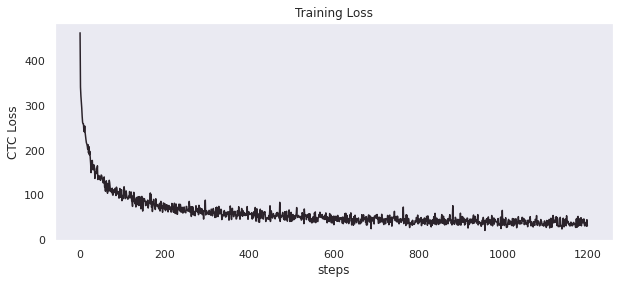

In [18]:
sns.set_palette(sns.dark_palette("purple"))
fig, ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(ax=ax,y=loss_values, x=range(len(loss_values)))
plot.set_title("Training Loss")
plot.set_xlabel("steps")
plot.set_ylabel("CTC Loss")
plt.show()

## Using The Model for converting a page

### Cleaning The Ouput
Due to the CTCLoss we should clear the ouput from repeated characters then `-` (blank) characters. 

In [19]:
import re
def clean_ctc(s):
    # remove repeated
    word = ""
    prev = ""
    for c in s:
      if(c != prev):
        word += c
      prev = c
    word = re.sub('[\-SE]', '', word)
    return word

### Converting Output Tensor To Word

In [20]:
def tensor_to_word(word_tensor):
    word_tensor = word_tensor.max(2)[1].view(-1)
    word = ""
    for i in range(word_tensor.size(0)):
      word += pchars[word_tensor[i]]
    return clean_ctc(word)

### Transforming Numpy Images for evaluation

In [21]:
def transform_numpy_image(img):
    # scale the image
    img = img.reshape(1, 1, 50, 100)
    tensor = torch.from_numpy(img).double().to(device)
    return tensor

### Feeding Image to Model 

In [22]:
def image_to_word(img):
    tensor = transform_numpy_image(img)
    prediction = None
    net.eval()
    with torch.no_grad():
      hidden = torch.zeros((1, enc_dim)).double().to(device)
      output = get_start_token()
      letters = []
      for j in range(img_splits):
        step = int(img_width / img_splits)
        output, hidden = net(tensor[:, :, :, step*(img_splits-j-1):step*(img_splits-j)], output, hidden)
        letters.append(output)
      prediction = torch.cat(letters, dim=0).view(img_splits, 1, enc_dim)
    return tensor_to_word(prediction)

### Reading The Text Image

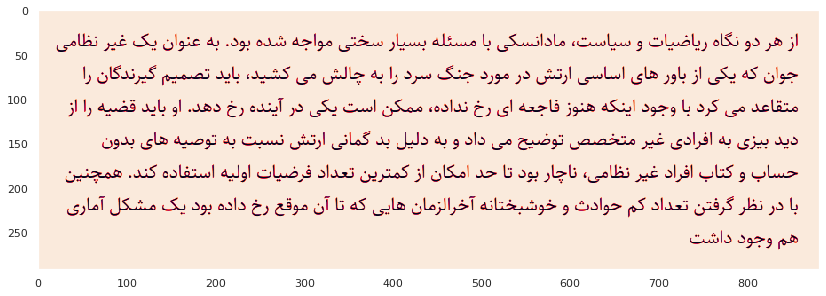

In [26]:
import cv2
%matplotlib inline
image_path = '/content/drive/MyDrive/NLP/test_page.png'

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

### Thresholding The Image

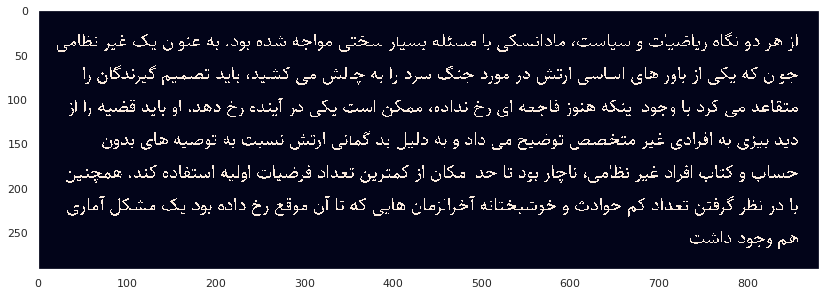

In [27]:
ret,thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(thresh, interpolation='nearest')

### Using dilation to segment the words

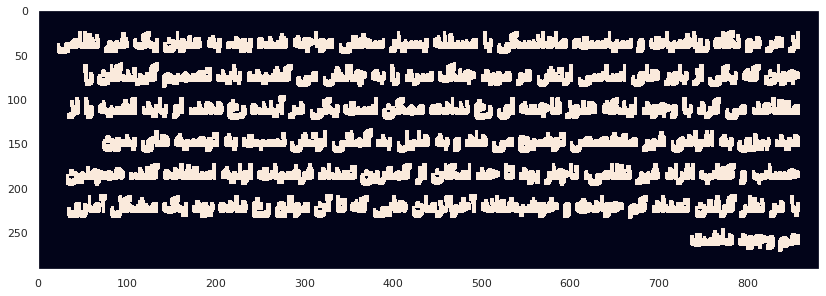

In [28]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 3))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 3)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(dilation, interpolation='nearest')

### Finding The Contours

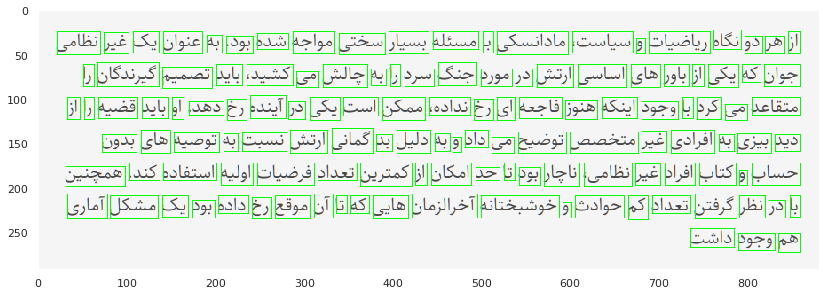

In [29]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
img_contours = img.copy()
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 255, 0), 1)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(img_contours, interpolation='nearest')

### Sorting The Contours

In [30]:
from functools import cmp_to_key

def rectCmp(r1, r2):
  if (abs(r1[1] - r2[1]) < 20):
    return r2[0] - r1[0]
  return r1[1] - r2[1]

bounding_rects = [ cv2.boundingRect(c) for c in contours ]
bounding_rects.sort(key=cmp_to_key(rectCmp))

### Extract Images

In [31]:
def extract_images(rects, image):
  images = []
  for r in rects:
    x, y, w, h = r
    H=50
    W=100
    Y = int((H-h)/2) - 5
    X = int((W-w)/2) - 5
    c = np.zeros((H, W))
    c[Y:Y+h, X:X+w] = 1-image[y:y+h, x:x+w]
    c[c < 70] = 0
    c *= 1.8
    c[c > 255] = 255
    c = np.floor(c)
    images.append(c)
  return images
test_images = extract_images(bounding_rects, gray)

## Final Result
After 2 epochs the result should be meangful

In [32]:
' '.join([image_to_word(image) for image in test_images])

'از هر دو نجگاه ریاعشیات و سیاست مادانسکی با مسثلده بسیار سختی مواجه شده بود به عنوان یک عیر نظامی جوان که پنکی از بآور حای آساسی ارتش دار مورد چنشگ سرد را به چالش می کشید باید تصمیم گیرندگان را منتقاعد می کرد با وحون اینکه هنوز فاجعه اگ رح نداده ممکن است پنکی نار آینده رح دهد او باید قضیه را از دید بیزگ به افرادگ غیر متخعص توخیح مع داد و به دالیل بد گمانی ارتک نسبت به توصبیعه حای بدون حساسب و کتاب افراد عیر نخآمی ناجار بود تا حد آمکان از کمترین تعیداد فرخیات آولیه استفاده کند همجنیت با نار نظر گرفتن تمداد کم حوادتث و خوشبختانه آخرالزمان هایی که تا آن موقح رچ داده بود یک مشکل آمارک هم وحون داشت'

## References
This paper helped me a lot, however my architecture is not same
- https://arxiv.org/abs/1805.09441
- [Pytorch Tutorial on RNNs](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)  
For word segmentation using dilation see this:
- https://stackoverflow.com/a/10970473/4334320

The text of the image which I used to show the final result is a translation of this book:
- The Theory That Would Not Die, Sharon McGrayne